In [9]:
import os
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from collections import Counter

In [10]:
def setup_data():
    print("--- Starting Data Download/Load ---")
    
    # 1. Download/Load Tiny ImageNet
    dataset = load_dataset("zh-plus/tiny-imagenet")
    
    print("\n--- Dataset Summary ---")
    print(dataset)
    
    # 2. Verify splits
    # Tiny ImageNet contains 100,000 images.
    train_count = len(dataset['train'])
    val_count = len(dataset['valid'])
    print(f"Training images: {train_count}")
    print(f"Validation images: {val_count}")

    # 3. Simple EDA: Visualizing a few samples
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        sample = dataset['train'][i]
        img = sample['image']
        label = sample['label']
        
        # Tiny ImageNet images are 64x64.
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    
    plt.show()
    
    return dataset

--- Starting Data Download/Load ---

--- Dataset Summary ---
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 100000
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})
Training images: 100000
Validation images: 10000


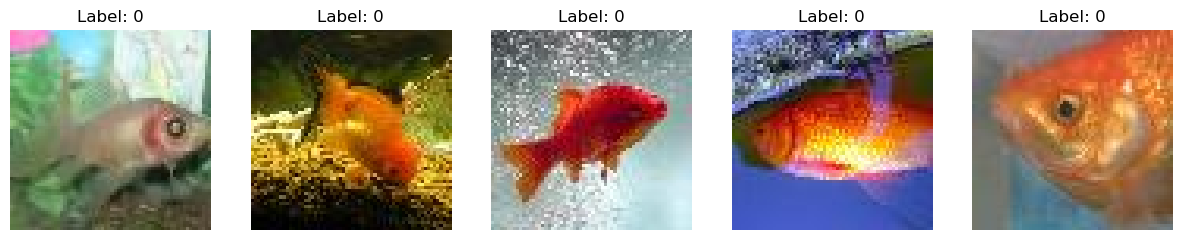

In [3]:
data = setup_data()

## EDA

### Target

In [15]:
def plot_class_distribution(dataset):

    num_classes = 200
    classes = list(range(num_classes))
    train_labels = dataset['train']['label']
    val_labels = dataset['valid']['label']
    train_counts = Counter(train_labels)
    val_counts = Counter(val_labels)
    train_freq = [train_counts[i] for i in classes]
    val_freq = [val_counts[i] for i in classes]

    # 3. Create the Plot
    plt.figure(figsize=(16, 6))
    
    # Plot training data distribution
    plt.bar(classes, train_freq, color='skyblue', label='Train', alpha=0.7)
    # Plot validation data distribution (often much smaller, so we overlay)
    plt.bar(classes, val_freq, color='orange', label='Validation', alpha=0.7)
    
    plt.axhline(y=500, color='r', linestyle='--', label='Target (500/class)')
    
    plt.xlabel('Class Index (0-199)')
    plt.ylabel('Number of Images')
    plt.title('Tiny ImageNet Class Distribution')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("class_distribution.png") # Saving for documentation
    plt.show()
    

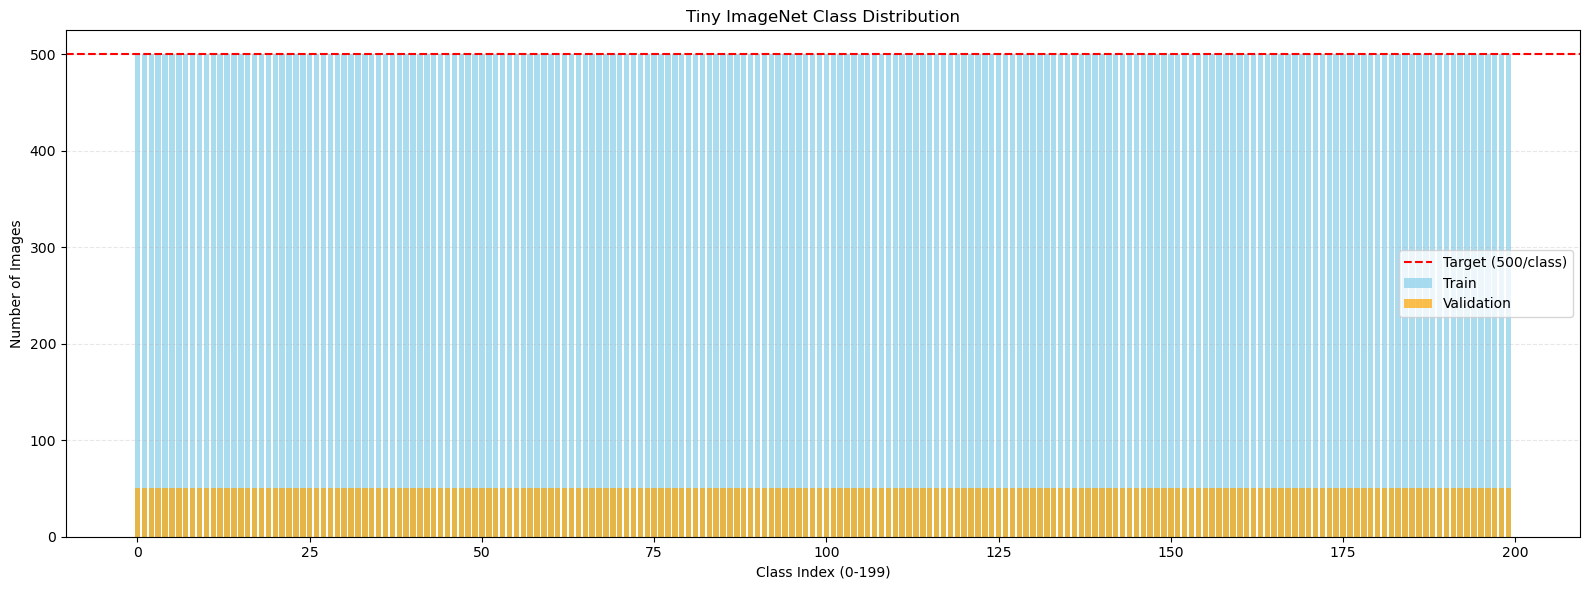

In [16]:
plot_class_distribution(data)

All the classes are perfectly balanced with 500 images per class (200 classes).

This implied that there are risk in "overfitting".

In [ ]:
def check_image_sizes(dataset):
    sizes = [img['image'].size for img in dataset['train']]
    unique_sizes = set(sizes)
    print(f"Unique image sizes in training set: {unique_sizes}")

    return unique_sizes

def 